In [1]:
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
import datetime as dt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import joblib
import datetime as dt
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#Paths for all datasets
path_train = 'datasets/train.csv'
path_client = 'datasets/client.csv'
path_gas_prices = 'datasets/gas_prices.csv'
path_forecast_weather = 'datasets/forecast_weather.csv'
path_weather_to_county = 'datasets/weather_station_to_county_mapping.csv'
path_electricity_prices = 'datasets/electricity_prices.csv'
path_historical_weather = 'datasets/historical_weather.csv'

In [3]:
train_df = pd.read_csv(
    path_train, 
    parse_dates=['datetime'])

fw_df = pd.read_csv(
    path_forecast_weather, 
    parse_dates=['forecast_datetime', "origin_datetime"])

hw_df = pd.read_csv(
    path_historical_weather, 
    parse_dates=['datetime'])

client_df = pd.read_csv(
    path_client,
    parse_dates=['date'])

gas_prices_df = pd.read_csv(
    path_gas_prices,
    parse_dates=['forecast_date'])

electricity_df = pd.read_csv(
    path_electricity_prices,
    parse_dates=['forecast_date'])

weather_station_to_county_mapping = pd.read_csv(path_weather_to_county)

In [4]:
historical_weather_cols = ['datetime', 'temperature', 'dewpoint', 'rain', 
                           'snowfall', 'surface_pressure', 'cloudcover_total', 
                           'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 
                           'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 
                           'direct_solar_radiation', 'diffuse_radiation']

forecast_weather_cols = ['hours_ahead', 'temperature', 'dewpoint', 
                         'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 
                         'cloudcover_total', '10_metre_u_wind_component',
                         '10_metre_v_wind_component', 'forecast_datetime', 
                         'direct_solar_radiation', 'surface_solar_radiation_downwards', 
                         'snowfall', 'total_precipitation']

In [5]:
# df creating date feature
train_df["date"] = train_df["datetime"].dt.date
train_df["date"] = pd.to_datetime(train_df["date"])

# merging train_df with client_df
df = (train_df
      .merge(
          client_df.drop(columns=["data_block_id"]),
          how="left",
          on=["county", "is_business", "product_type","date"]
          )
     )

df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,eic_count,installed_capacity
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,108.0,952.89
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,108.0,952.89
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,17.0,166.40
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,17.0,166.40
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,688.0,7207.88
...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,NaN,NaN
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,NaN,NaN
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,NaN,NaN
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,NaN,NaN


In [6]:
# in gas_prices_df, drop origin_date and rename forecast_date
gas_prices_df = (gas_prices_df
                 .drop(columns=["origin_date"])
                 .rename(columns={"forecast_date": "date"})
                )

# merge gas_prices_df with df
df = (df
      .merge(
          gas_prices_df.drop(columns=["data_block_id"]),
          how="left", 
          on=["date"]
          )
      )

df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,108.0,952.89,45.23,46.32
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,108.0,952.89,45.23,46.32
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,17.0,166.40,45.23,46.32
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,17.0,166.40,45.23,46.32
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,688.0,7207.88,45.23,46.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,NaN,NaN,NaN,NaN
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,NaN,NaN,NaN,NaN
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,NaN,NaN,NaN,NaN
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,NaN,NaN,NaN,NaN


In [7]:
# electricity
electricity_df = (electricity_df
                  .drop(columns=["origin_date"])
                  .rename(columns={"forecast_date": "datetime"})
                  )

electricity_df["datetime"] = (pd.to_datetime(electricity_df["datetime"])
                              + pd.Timedelta(days=1)
                              )

electricity_df["euros_per_mwh"] = (electricity_df["euros_per_mwh"].abs() 
                                   + 0.1)

# merging df with electricity_df
df = (df
      .merge(
          electricity_df.drop(columns=["data_block_id"]),
          how="left",
          on=[ "datetime"]
          )
     )


df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,108.0,952.89,45.23,46.32,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,108.0,952.89,45.23,46.32,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,17.0,166.40,45.23,46.32,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,17.0,166.40,45.23,46.32,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,688.0,7207.88,45.23,46.32,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,NaN,NaN,NaN,NaN,1.39
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,NaN,NaN,NaN,NaN,1.39
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,NaN,NaN,NaN,NaN,1.39
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,NaN,NaN,NaN,NaN,1.39


In [8]:
# fw_df 
fw_df["datetime"] = (pd.to_datetime(fw_df["origin_datetime"])
                     + pd.to_timedelta(fw_df["hours_ahead"], unit='h')
                     )

fw_df = (fw_df
         .assign(
             latitude=fw_df["latitude"].astype('float32').round(1),
             longitude=fw_df["longitude"].astype('float32').round(1),
             data_block_id=fw_df["data_block_id"].astype('int64')
             )
         )


fw_df

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,datetime
0,57.599998,21.700001,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
1,57.599998,22.200001,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
2,57.599998,22.700001,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
3,57.599998,23.200001,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
4,57.599998,23.700001,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.700001,26.200001,2023-05-30 02:00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00
3424508,59.700001,26.700001,2023-05-30 02:00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00
3424509,59.700001,27.200001,2023-05-30 02:00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00
3424510,59.700001,27.700001,2023-05-30 02:00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00


In [9]:
weather_station_to_county_mapping = (weather_station_to_county_mapping
                                     .assign(
                                         latitude=weather_station_to_county_mapping["latitude"].astype('float32').round(1),
                                         longitude=weather_station_to_county_mapping["longitude"].astype('float32').round(1)
                                         )
                                     )


# merging weather forecast dataset with weather_station_to_county_mapping
fw_df = (fw_df
         .merge(
             weather_station_to_county_mapping.drop(columns=["county_name"]),
             how="left",
             on=["longitude", "latitude"]
             )
         .drop(columns=["longitude", "latitude", "origin_datetime"])
         )

fw_df

,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,datetime,county
0,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
1,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
2,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
3,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
4,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,2021-09-01 03:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00,NaN
3424508,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00,NaN
3424509,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00,NaN
3424510,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0,2023-06-01 02:00:00,NaN


In [10]:
fw_df = (fw_df
         .groupby(["datetime", "data_block_id"])
         .agg({col: 'mean' for col in forecast_weather_cols})
         .reset_index()
         )

fw_df.columns = [f"fw_{col}" if col in forecast_weather_cols else col for col in fw_df.columns]

#fw_df["county"] = fw_df["county"].astype('int64')
fw_df = (fw_df
         .assign(
             data_block_id=fw_df["data_block_id"].astype('int64')
             )
         )


fw_df

,datetime,data_block_id,fw_hours_ahead,fw_temperature,fw_dewpoint,fw_cloudcover_high,fw_cloudcover_low,fw_cloudcover_mid,fw_cloudcover_total,fw_10_metre_u_wind_component,fw_10_metre_v_wind_component,fw_forecast_datetime,fw_direct_solar_radiation,fw_surface_solar_radiation_downwards,fw_snowfall,fw_total_precipitation
0,2021-09-01 03:00:00,1,1.0,13.062975,10.690589,0.292374,0.183447,0.062130,0.440905,1.959828,-5.292196,2021-09-01 03:00:00,0.000000,0.000000,0.0,0.000000e+00
1,2021-09-01 04:00:00,1,2.0,12.963464,10.582913,0.271825,0.178160,0.082486,0.427419,2.135921,-5.392188,2021-09-01 04:00:00,0.000000,0.000000,0.0,8.141090e-07
2,2021-09-01 05:00:00,1,3.0,12.832809,10.455104,0.255049,0.153885,0.098480,0.408272,2.295792,-5.488858,2021-09-01 05:00:00,0.000000,0.000000,0.0,6.782689e-07
3,2021-09-01 06:00:00,1,4.0,12.867699,10.403001,0.271870,0.141209,0.100900,0.425778,2.414418,-5.532233,2021-09-01 06:00:00,55.961786,9.927205,0.0,1.333654e-06
4,2021-09-01 07:00:00,1,5.0,13.339924,10.518761,0.248376,0.122084,0.085374,0.378721,2.533944,-5.632845,2021-09-01 07:00:00,247.383901,81.928539,0.0,1.371439e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30571,2023-05-31 22:00:00,637,44.0,11.729009,5.960873,0.416247,0.020762,0.027475,0.456015,4.466787,-2.069000,2023-05-31 22:00:00,3.715556,0.413333,0.0,0.000000e+00
30572,2023-05-31 23:00:00,637,45.0,11.137857,5.725789,0.504970,0.016986,0.031082,0.526855,4.432824,-2.405810,2023-05-31 23:00:00,0.010794,0.000000,0.0,0.000000e+00
30573,2023-06-01 00:00:00,637,46.0,10.659773,5.493812,0.394751,0.016852,0.030581,0.397820,4.368315,-2.626136,2023-06-01 00:00:00,0.000000,0.000000,0.0,0.000000e+00
30574,2023-06-01 01:00:00,637,47.0,10.236302,5.293022,0.309380,0.021396,0.034688,0.317103,4.359639,-2.748081,2023-06-01 01:00:00,0.000000,0.000000,0.0,0.000000e+00


In [11]:
df = df.merge(
    fw_df, 
    how="left", 
    on=["datetime","data_block_id"]
    )

# Converting Celcius to Kelvin
df["fw_new_feature"] = (df["installed_capacity"]
                        * df["fw_surface_solar_radiation_downwards"]
                        / (df["fw_temperature"]+ 273.15)
                        )

df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,fw_cloudcover_mid,fw_cloudcover_total,fw_10_metre_u_wind_component,fw_10_metre_v_wind_component,fw_forecast_datetime,fw_direct_solar_radiation,fw_surface_solar_radiation_downwards,fw_snowfall,fw_total_precipitation,fw_new_feature
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,...,0.031082,0.526855,4.432824,-2.40581,2023-05-31 23:00:00,0.010794,0.0,0.0,0.0,NaN
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,...,0.031082,0.526855,4.432824,-2.40581,2023-05-31 23:00:00,0.010794,0.0,0.0,0.0,NaN
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,...,0.031082,0.526855,4.432824,-2.40581,2023-05-31 23:00:00,0.010794,0.0,0.0,0.0,NaN
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,...,0.031082,0.526855,4.432824,-2.40581,2023-05-31 23:00:00,0.010794,0.0,0.0,0.0,NaN


In [12]:
# Convert 'datetime' column to datetime format and shift by one day
hw_df["datetime"] = pd.to_datetime(hw_df["datetime"]) + pd.Timedelta(days=1)

# 1- Convert 'latitude' and 'longitude' columns to float32 and round to 1 decimal place 
# 2- Convert 'data_block_id' column to int64
hw_df = (hw_df
         .assign(
             latitude=hw_df["latitude"].astype('float32').round(1),
             longitude=hw_df["longitude"].astype('float32').round(1),
             data_block_id=hw_df["data_block_id"].astype('int64')
             )
        )

# Merging hw_df (historical weather dataframe) with weather_station_to_county_mapping 
hw_df = (hw_df
         .merge(
             weather_station_to_county_mapping.drop(columns=["county_name"]),
             how="left",
             on=["longitude", "latitude"]
             )
         .drop(columns=["longitude", "latitude"])
         )

# Group by 'datetime' and 'data_block_id', calculating mean for historical weather columns
hw_df = (hw_df
         .groupby(["datetime", "data_block_id"])
         .agg({col: 'mean' for col in historical_weather_cols})
         .rename(columns={col: f"hw_{col}" for col in historical_weather_cols})
         .reset_index()
         )

# Reset index and adjust 'datetime' based on the hour

hw_df = (hw_df
         .assign(
             datetime=np.where(
                 hw_df["datetime"].dt.hour > 10,
                 hw_df["datetime"] + pd.Timedelta(days=1),
                 hw_df["datetime"]
                 ),
             data_block_id=hw_df["data_block_id"].astype('int64')
             )
         )


# Merge the processed historical weather DataFrame with the main DataFrame
df = df.merge(
    hw_df,
    how="left", 
    on=["datetime", "data_block_id"]
    )

In [13]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

In [14]:
df['season'] = df['datetime'].apply(get_season)
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,hw_cloudcover_total,hw_cloudcover_low,hw_cloudcover_mid,hw_cloudcover_high,hw_windspeed_10m,hw_winddirection_10m,hw_shortwave_radiation,hw_direct_solar_radiation,hw_diffuse_radiation,season
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Autumn
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Autumn
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Autumn
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Autumn
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,...,47.330357,1.517857,53.732143,47.008929,2.583085,247.794643,0.0,0.0,0.0,Spring
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,...,47.330357,1.517857,53.732143,47.008929,2.583085,247.794643,0.0,0.0,0.0,Spring
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,...,47.330357,1.517857,53.732143,47.008929,2.583085,247.794643,0.0,0.0,0.0,Spring
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,...,47.330357,1.517857,53.732143,47.008929,2.583085,247.794643,0.0,0.0,0.0,Spring


In [15]:
lags = [1,2,3,4,5,6]

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['target_lag_' + str(lag)] = (dataframe
                                               .groupby(["prediction_unit_id","is_consumption"])['target']
                                               .transform(lambda x: x.shift(lag))
                                              )
    return dataframe

In [16]:
df = lag_features(df,lags=lags)

In [17]:
df = (df
      .set_index("datetime", drop=True)
      .dropna(subset=['target'])
      .drop(["date"], axis=1)
     )

df

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,eic_count,installed_capacity,...,hw_shortwave_radiation,hw_direct_solar_radiation,hw_diffuse_radiation,season,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,0,0,1,0.713,0,0,0,0,108.0,952.89,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0,0,1,96.590,1,0,1,0,108.0,952.89,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0,0,2,0.000,0,0,2,1,17.0,166.40,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0,0,2,17.314,1,0,3,1,17.0,166.40,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0,0,3,2.904,0,0,4,2,688.0,7207.88,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 23:00:00,15,1,0,197.233,1,637,2018347,64,NaN,NaN,...,0.0,0.0,0.0,Spring,207.244,323.350,537.154,530.777,519.337,494.629
2023-05-31 23:00:00,15,1,1,0.000,0,637,2018348,59,NaN,NaN,...,0.0,0.0,0.0,Spring,0.000,2.840,25.563,59.005,108.043,227.997
2023-05-31 23:00:00,15,1,1,28.404,1,637,2018349,59,NaN,NaN,...,0.0,0.0,0.0,Spring,36.083,24.250,13.756,13.353,11.033,6.726


In [18]:

for col in ["eic_count", "installed_capacity"]:
    df[col] = df.groupby(["prediction_unit_id"])[col].transform(lambda x: x.ffill())

df

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,eic_count,installed_capacity,...,hw_shortwave_radiation,hw_direct_solar_radiation,hw_diffuse_radiation,season,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,0,0,1,0.713,0,0,0,0,108.0,952.89,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0,0,1,96.590,1,0,1,0,108.0,952.89,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0,0,2,0.000,0,0,2,1,17.0,166.40,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0,0,2,17.314,1,0,3,1,17.0,166.40,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-01 00:00:00,0,0,3,2.904,0,0,4,2,688.0,7207.88,...,NaN,NaN,NaN,Autumn,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 23:00:00,15,1,0,197.233,1,637,2018347,64,15.0,620.00,...,0.0,0.0,0.0,Spring,207.244,323.350,537.154,530.777,519.337,494.629
2023-05-31 23:00:00,15,1,1,0.000,0,637,2018348,59,20.0,624.50,...,0.0,0.0,0.0,Spring,0.000,2.840,25.563,59.005,108.043,227.997
2023-05-31 23:00:00,15,1,1,28.404,1,637,2018349,59,20.0,624.50,...,0.0,0.0,0.0,Spring,36.083,24.250,13.756,13.353,11.033,6.726


In [19]:
df.dropna(inplace=True)
df

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,eic_count,installed_capacity,...,hw_shortwave_radiation,hw_direct_solar_radiation,hw_diffuse_radiation,season,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-02 00:00:00,0,0,1,1.687,0,1,2928,0,108.0,952.89,...,6.3125,4.919643,1.392857,Autumn,2.869,2.122,2.010,1.898,10.703,61.903
2021-09-02 00:00:00,0,0,1,109.366,1,1,2929,0,108.0,952.89,...,6.3125,4.919643,1.392857,Autumn,127.531,129.917,157.872,143.479,109.220,72.920
2021-09-02 00:00:00,0,0,2,0.000,0,1,2930,1,17.0,166.40,...,6.3125,4.919643,1.392857,Autumn,0.000,0.000,0.000,0.004,2.188,11.869
2021-09-02 00:00:00,0,0,2,21.008,1,1,2931,1,17.0,166.40,...,6.3125,4.919643,1.392857,Autumn,20.257,24.127,23.957,22.718,17.612,18.344
2021-09-02 00:00:00,0,0,3,1.003,0,1,2932,2,688.0,7207.88,...,6.3125,4.919643,1.392857,Autumn,3.536,4.771,3.693,4.466,80.164,520.481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29 23:00:00,15,1,0,188.167,1,635,2012107,64,15.0,620.00,...,0.0000,0.000000,0.000000,Spring,212.626,319.341,535.382,536.216,537.724,503.755
2023-05-29 23:00:00,15,1,1,0.000,0,635,2012108,59,20.0,624.50,...,0.0000,0.000000,0.000000,Spring,0.000,1.140,28.488,81.165,95.324,203.402
2023-05-29 23:00:00,15,1,1,31.484,1,635,2012109,59,20.0,624.50,...,0.0000,0.000000,0.000000,Spring,33.624,34.176,31.293,23.134,14.558,9.139


In [20]:
df.isnull().any()

county                                  False
is_business                             False
product_type                            False
target                                  False
is_consumption                          False
data_block_id                           False
row_id                                  False
prediction_unit_id                      False
eic_count                               False
installed_capacity                      False
lowest_price_per_mwh                    False
highest_price_per_mwh                   False
euros_per_mwh                           False
fw_hours_ahead                          False
fw_temperature                          False
fw_dewpoint                             False
fw_cloudcover_high                      False
fw_cloudcover_low                       False
fw_cloudcover_mid                       False
fw_cloudcover_total                     False
fw_10_metre_u_wind_component            False
fw_10_metre_v_wind_component      

In [21]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
  It returns categorical, numerical and cardinal variables' names and their quantities
  
  Parameters
  ----------
  dataframe: dataframe
      the dataframe where we take the variables' names
  cat_th: int, float
      class threshold value for variables that are numeric but categorical
  car_th: int, float
      class threshold value for variables that are categorical but cardinal

  Returns
  -------
      cat_cols: list
          list of Categorical variables
      num_cols: list
          list of Numerical variables
      cat_but_car: list
          List of Cardinal variables with Categorical view
  Notes
  -----
  cat_cols + num_cols + cat_but_car = all variables
  num_but_cat in cat_cols

  """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtype != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtype == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [22]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = (pd.get_dummies(dataframe,
                                columns=categorical_cols,
                                drop_first=drop_first)
                )
    return dataframe

In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(df,cat_th=17)

Observations: 2003538
Variables: 50
cat_cols: 5
num_cols: 45
cat_but_car: 0
num_but_cat: 4


In [24]:
df = one_hot_encoder(df, ['county', 'is_business', 'product_type', 'is_consumption',"prediction_unit_id","season"])

In [25]:
df.drop(columns="row_id", axis=1, inplace=True)

In [26]:
df.dtypes

target                   float64
data_block_id              int64
eic_count                float64
installed_capacity       float64
lowest_price_per_mwh     float64
                          ...   
prediction_unit_id_67       bool
prediction_unit_id_68       bool
season_Spring               bool
season_Summer               bool
season_Winter               bool
Length: 134, dtype: object

In [27]:

boolean_columns = df.select_dtypes(include='bool').columns


df[boolean_columns] = df[boolean_columns].astype(int)


In [28]:
df

,target,data_block_id,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,fw_hours_ahead,fw_temperature,fw_dewpoint,...,prediction_unit_id_62,prediction_unit_id_63,prediction_unit_id_64,prediction_unit_id_65,prediction_unit_id_66,prediction_unit_id_67,prediction_unit_id_68,season_Spring,season_Summer,season_Winter
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-02 00:00:00,1.687,1,108.0,952.89,45.62,46.29,92.61,22.0,11.318849,6.304401,...,0,0,0,0,0,0,0,0,0,0
2021-09-02 00:00:00,109.366,1,108.0,952.89,45.62,46.29,92.61,22.0,11.318849,6.304401,...,0,0,0,0,0,0,0,0,0,0
2021-09-02 00:00:00,0.000,1,17.0,166.40,45.62,46.29,92.61,22.0,11.318849,6.304401,...,0,0,0,0,0,0,0,0,0,0
2021-09-02 00:00:00,21.008,1,17.0,166.40,45.62,46.29,92.61,22.0,11.318849,6.304401,...,0,0,0,0,0,0,0,0,0,0
2021-09-02 00:00:00,1.003,1,688.0,7207.88,45.62,46.29,92.61,22.0,11.318849,6.304401,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29 23:00:00,188.167,635,15.0,620.00,28.16,36.98,69.60,45.0,9.748298,2.515632,...,0,0,1,0,0,0,0,1,0,0
2023-05-29 23:00:00,0.000,635,20.0,624.50,28.16,36.98,69.60,45.0,9.748298,2.515632,...,0,0,0,0,0,0,0,1,0,0
2023-05-29 23:00:00,31.484,635,20.0,624.50,28.16,36.98,69.60,45.0,9.748298,2.515632,...,0,0,0,0,0,0,0,1,0,0


In [29]:
train = df[df["data_block_id"]<= 500]

In [30]:
train.drop(columns="data_block_id", axis=1, inplace=True)

C:\Users\MEHMET\AppData\Local\Temp\ipykernel_20080\3642702528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns="data_block_id", axis=1, inplace=True)


In [31]:
train

,target,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,fw_hours_ahead,fw_temperature,fw_dewpoint,fw_cloudcover_high,...,prediction_unit_id_62,prediction_unit_id_63,prediction_unit_id_64,prediction_unit_id_65,prediction_unit_id_66,prediction_unit_id_67,prediction_unit_id_68,season_Spring,season_Summer,season_Winter
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-02 00:00:00,1.687,108.0,952.89,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,0
2021-09-02 00:00:00,109.366,108.0,952.89,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,0
2021-09-02 00:00:00,0.000,17.0,166.40,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,0
2021-09-02 00:00:00,21.008,17.0,166.40,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,0
2021-09-02 00:00:00,1.003,688.0,7207.88,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-14 23:00:00,216.302,15.0,620.00,58.75,75.00,68.40,46.0,3.260092,2.073733,0.582846,...,0,0,1,0,0,0,0,0,0,1
2023-01-14 23:00:00,0.000,22.0,779.50,58.75,75.00,68.40,46.0,3.260092,2.073733,0.582846,...,0,0,0,0,0,0,0,0,0,1
2023-01-14 23:00:00,167.773,22.0,779.50,58.75,75.00,68.40,46.0,3.260092,2.073733,0.582846,...,0,0,0,0,0,0,0,0,0,1


In [32]:
test = df[df["data_block_id"] > 500]

In [33]:
test.drop(columns="data_block_id", axis=1, inplace=True)

C:\Users\MEHMET\AppData\Local\Temp\ipykernel_20080\897287909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns="data_block_id", axis=1, inplace=True)


In [34]:
test

,target,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,fw_hours_ahead,fw_temperature,fw_dewpoint,fw_cloudcover_high,...,prediction_unit_id_62,prediction_unit_id_63,prediction_unit_id_64,prediction_unit_id_65,prediction_unit_id_66,prediction_unit_id_67,prediction_unit_id_68,season_Spring,season_Summer,season_Winter
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-15 00:00:00,0.005,387.0,3650.78,60.00,70.00,49.81,23.0,3.256149,2.012544,0.558161,...,0,0,0,0,0,0,0,0,0,1
2023-01-15 00:00:00,712.806,387.0,3650.78,60.00,70.00,49.81,23.0,3.256149,2.012544,0.558161,...,0,0,0,0,0,0,0,0,0,1
2023-01-15 00:00:00,0.000,24.0,110.90,60.00,70.00,49.81,23.0,3.256149,2.012544,0.558161,...,0,0,0,0,0,0,0,0,0,1
2023-01-15 00:00:00,30.796,24.0,110.90,60.00,70.00,49.81,23.0,3.256149,2.012544,0.558161,...,0,0,0,0,0,0,0,0,0,1
2023-01-15 00:00:00,0.025,1317.0,13498.11,60.00,70.00,49.81,23.0,3.256149,2.012544,0.558161,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29 23:00:00,188.167,15.0,620.00,28.16,36.98,69.60,45.0,9.748298,2.515632,0.621994,...,0,0,1,0,0,0,0,1,0,0
2023-05-29 23:00:00,0.000,20.0,624.50,28.16,36.98,69.60,45.0,9.748298,2.515632,0.621994,...,0,0,0,0,0,0,0,1,0,0
2023-05-29 23:00:00,31.484,20.0,624.50,28.16,36.98,69.60,45.0,9.748298,2.515632,0.621994,...,0,0,0,0,0,0,0,1,0,0


In [35]:
y_train = train["target"]
X_train = train.drop("target", axis=1)

In [36]:
y_test = test["target"]
X_test = test.drop("target", axis=1)

In [37]:
X_train = X_train.select_dtypes(exclude=['datetime64[ns]'])
X_test = X_test.select_dtypes(exclude=['datetime64[ns]'])


In [38]:
lgbm_model = LGBMRegressor()

lgbm_random={'subsample_for_bin': 345895,
             'num_leaves': 63,
             'n_estimators': 5227,
             'min_split_gain': 0.12083725162852055,
             'min_child_weight': 0.03807974066189634,
             'min_child_samples': 49,
             'learning_rate': 0.08685740003902279,
             'colsample_bytree': 0.7722564662082128}

In [39]:
lgbm_final = (lgbm_model
              .set_params(**lgbm_random, random_state=42)
              .fit(X_train,y_train)
             )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9869
[LightGBM] [Info] Number of data points in the train set: 1575092, number of used features: 130
[LightGBM] [Info] Start training from score 257.589363


In [40]:
test_pred = lgbm_final.predict(X_test)

In [41]:
print(mean_absolute_error(y_test,test_pred))

34.67960519652442


In [42]:
df.drop(columns="data_block_id", inplace=True)

In [43]:
df = df.select_dtypes(exclude=['datetime64[ns]'])


In [44]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_x = df.drop(columns="target").values
train_y = df["target"].values

X = scaler_X.fit_transform(train_x)
y = scaler_y.fit_transform(train_y.reshape(-1, 1))

In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(96, input_dim=X.shape[1], activation="relu"),
    #tf.keras.layers.Dense(32, activation="relu"),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

c:\Users\MEHMET\Desktop\enefit\evenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=3,          
                               restore_best_weights=True)

In [47]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.Huber(), 
              metrics=['mean_absolute_error'])

In [48]:
history = model.fit(X, y, 
                    epochs=100,
                    validation_split=0.2,            
                    batch_size=16, 
                    callbacks=[early_stopping])

Epoch 1/100
100177/100177 ━━━━━━━━━━━━━━━━━━━━ 67s 660us/step - loss: 9.2513e-05 - mean_absolute_error: 0.0065 - val_loss: 3.5958e-05 - val_mean_absolute_error: 0.0036
Epoch 2/100
100177/100177 ━━━━━━━━━━━━━━━━━━━━ 64s 640us/step - loss: 1.6090e-05 - mean_absolute_error: 0.0030 - val_loss: 2.7604e-05 - val_mean_absolute_error: 0.0034
Epoch 3/100
100177/100177 ━━━━━━━━━━━━━━━━━━━━ 66s 660us/step - loss: 1.4851e-05 - mean_absolute_error: 0.0026 - val_loss: 2.6665e-05 - val_mean_absolute_error: 0.0032
Epoch 4/100
100177/100177 ━━━━━━━━━━━━━━━━━━━━ 66s 658us/step - loss: 1.3864e-05 - mean_absolute_error: 0.0025 - val_loss: 2.6268e-05 - val_mean_absolute_error: 0.0034
Epoch 5/100
100177/100177 ━━━━━━━━━━━━━━━━━━━━ 66s 658us/step - loss: 1.3651e-05 - mean_absolute_error: 0.0025 - val_loss: 2.7124e-05 - val_mean_absolute_error: 0.0034
Epoch 6/100
100177/100177 ━━━━━━━━━━━━━━━━━━━━ 66s 657us/step - loss: 1.3238e-05 - mean_absolute_error: 0.0024 - val_loss: 2.6363e-05 - val_mean_absolute_error:

In [49]:
predictions = model.predict(X)

62611/62611 ━━━━━━━━━━━━━━━━━━━━ 29s 465us/step


In [50]:
predictions = scaler_y.inverse_transform(predictions)

In [51]:
y = scaler_y.inverse_transform(y)

In [52]:
print(predictions[:10])

[[ 15.358495]
 [113.799194]
 [ 15.358495]
 [ 15.358495]
 [ 15.358495]
 [641.7338  ]
 [ 15.358495]
 [115.01742 ]
 [ 15.358495]
 [505.83304 ]]


In [53]:
y[:10]

array([[  1.687],
       [109.366],
       [  0.   ],
       [ 21.008],
       [  1.003],
       [735.696],
       [  0.   ],
       [ 75.8  ],
       [  0.   ],
       [502.241]])

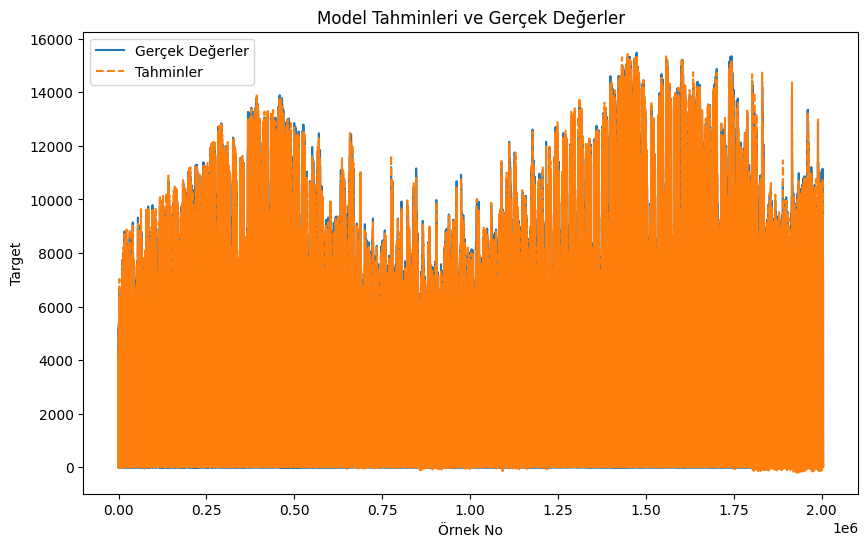

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Gerçek Değerler')
plt.plot(predictions, label='Tahminler', linestyle='--')
plt.title('Model Tahminleri ve Gerçek Değerler')
plt.xlabel('Örnek No')
plt.ylabel('Target')
plt.legend()
plt.show()

In [55]:
print(mean_absolute_error(y, predictions))

34.93729253061303


In [56]:
predictions.shape

(2003538, 1)

In [57]:
df["dnn_predictions"] = predictions

In [58]:
df.shape

(2003538, 132)

In [59]:
lgbm_comb_model = LGBMRegressor()

In [60]:
df.select_dtypes(exclude=['datetime64[ns]'])
df

,target,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,fw_hours_ahead,fw_temperature,fw_dewpoint,fw_cloudcover_high,...,prediction_unit_id_63,prediction_unit_id_64,prediction_unit_id_65,prediction_unit_id_66,prediction_unit_id_67,prediction_unit_id_68,season_Spring,season_Summer,season_Winter,dnn_predictions
datetime,,,,,,,,,,,,,,,,,,,,,
2021-09-02 00:00:00,1.687,108.0,952.89,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,15.358495
2021-09-02 00:00:00,109.366,108.0,952.89,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,113.799194
2021-09-02 00:00:00,0.000,17.0,166.40,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,15.358495
2021-09-02 00:00:00,21.008,17.0,166.40,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,15.358495
2021-09-02 00:00:00,1.003,688.0,7207.88,45.62,46.29,92.61,22.0,11.318849,6.304401,0.000000,...,0,0,0,0,0,0,0,0,0,15.358495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29 23:00:00,188.167,15.0,620.00,28.16,36.98,69.60,45.0,9.748298,2.515632,0.621994,...,0,1,0,0,0,0,1,0,0,207.667343
2023-05-29 23:00:00,0.000,20.0,624.50,28.16,36.98,69.60,45.0,9.748298,2.515632,0.621994,...,0,0,0,0,0,0,1,0,0,15.358495
2023-05-29 23:00:00,31.484,20.0,624.50,28.16,36.98,69.60,45.0,9.748298,2.515632,0.621994,...,0,0,0,0,0,0,1,0,0,96.057159


In [61]:
train_size = int(len(df) * 0.8)

train, test = df[:train_size], df[train_size:]

train_X = train.drop(columns="target")
train_y = train["target"]

test_X = test.drop(columns="target")
test_y = test["target"]

In [62]:
lgbm_comb_model.fit(train_X,train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10120
[LightGBM] [Info] Number of data points in the train set: 1602830, number of used features: 131
[LightGBM] [Info] Start training from score 258.706688


LGBMRegressor()

In [63]:
y_p = lgbm_comb_model.predict(test_X)

In [64]:
print(mean_absolute_error(test_y, y_p))

34.84648866746376


In [65]:
test_y = pd.DataFrame(test_y)

In [66]:
y_p = pd.DataFrame(y_p)

In [67]:
y_p

,0
0,-0.312729
1,1020.283473
2,0.006706
3,245.265433
4,0.316242
...,...
400703,205.314301
400704,0.443158
400705,50.183736
400706,-2.073251


In [68]:
test_y.reset_index(inplace=True)

In [69]:
test_y

,datetime,target
0,2023-01-23 16:00:00,0.007
1,2023-01-23 16:00:00,984.774
2,2023-01-23 16:00:00,0.000
3,2023-01-23 16:00:00,275.399
4,2023-01-23 16:00:00,0.000
...,...,...
400703,2023-05-29 23:00:00,188.167
400704,2023-05-29 23:00:00,0.000
400705,2023-05-29 23:00:00,31.484
400706,2023-05-29 23:00:00,0.000


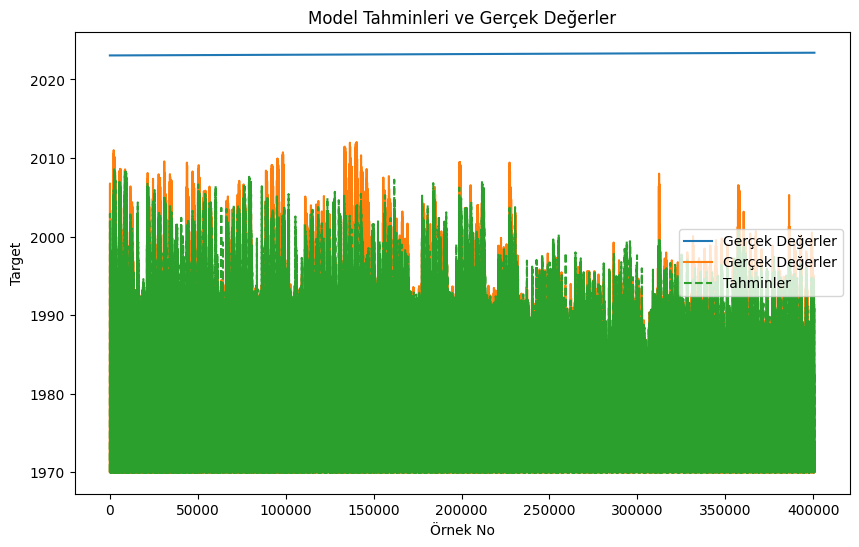

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Gerçek Değerler')
plt.plot(y_p, label='Tahminler', linestyle='--')
plt.title('Model Tahminleri ve Gerçek Değerler')
plt.xlabel('Örnek No')
plt.ylabel('Target')
plt.legend()
plt.show()

In [71]:
import pickle

In [72]:
with open('lgbm_comb_model.pkl', 'wb') as f:
    pickle.dump(lgbm_comb_model, f)

In [73]:
test_X.to_csv("comb_data.csv")
test_y.to_csv("comb_target.csv")

In [74]:
test_X

,eic_count,installed_capacity,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,fw_hours_ahead,fw_temperature,fw_dewpoint,fw_cloudcover_high,fw_cloudcover_low,...,prediction_unit_id_63,prediction_unit_id_64,prediction_unit_id_65,prediction_unit_id_66,prediction_unit_id_67,prediction_unit_id_68,season_Spring,season_Summer,season_Winter,dnn_predictions
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-23 16:00:00,64.0,1872.1,67.00,71.91,171.13,39.0,-3.390945,-5.524416,0.008331,0.969691,...,0,0,0,0,0,0,0,0,1,15.358495
2023-01-23 16:00:00,64.0,1872.1,67.00,71.91,171.13,39.0,-3.390945,-5.524416,0.008331,0.969691,...,0,0,0,0,0,0,0,0,1,1004.307800
2023-01-23 16:00:00,125.0,1312.7,67.00,71.91,171.13,39.0,-3.390945,-5.524416,0.008331,0.969691,...,0,0,0,0,0,0,0,0,1,15.358495
2023-01-23 16:00:00,125.0,1312.7,67.00,71.91,171.13,39.0,-3.390945,-5.524416,0.008331,0.969691,...,0,0,0,0,0,0,0,0,1,215.645218
2023-01-23 16:00:00,12.0,52.0,67.00,71.91,171.13,39.0,-3.390945,-5.524416,0.008331,0.969691,...,0,0,0,0,0,0,0,0,1,15.358495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29 23:00:00,15.0,620.0,28.16,36.98,69.60,45.0,9.748298,2.515632,0.621994,0.000449,...,0,1,0,0,0,0,1,0,0,207.667343
2023-05-29 23:00:00,20.0,624.5,28.16,36.98,69.60,45.0,9.748298,2.515632,0.621994,0.000449,...,0,0,0,0,0,0,1,0,0,15.358495
2023-05-29 23:00:00,20.0,624.5,28.16,36.98,69.60,45.0,9.748298,2.515632,0.621994,0.000449,...,0,0,0,0,0,0,1,0,0,96.057159


In [75]:
test_y

,datetime,target
0,2023-01-23 16:00:00,0.007
1,2023-01-23 16:00:00,984.774
2,2023-01-23 16:00:00,0.000
3,2023-01-23 16:00:00,275.399
4,2023-01-23 16:00:00,0.000
...,...,...
400703,2023-05-29 23:00:00,188.167
400704,2023-05-29 23:00:00,0.000
400705,2023-05-29 23:00:00,31.484
400706,2023-05-29 23:00:00,0.000
